In [2]:
import numpy as np

# %% OVERALL PARAMETERS
numProducts = 4
products = np.arange(numProducts) + 1  # only real products (starting from 1)
revenues = np.array([1000, 800, 600, 400])  # only real products

T = 400

customer_segments_num = 1
arrivalProbability = 0.5
preference_weights = np.array([0.4, 0.8, 1.2, 1.6])

varNoPurchasePreferences = np.array([1, 2, 3])
varCapacity = np.arange(40, 120, 20)

preference_no_purchase = 1



# %% PACKAGES

# # Plot iPython
# %matplotlib notebook
# import matplotlib.pyplot as plt

# Plot Python
%matplotlib notebook
import matplotlib.pyplot as plt


# Data
import numpy as np
import pandas as pd

# Calculation and Counting
import itertools
import math

# Distributions
from scipy.stats import bernoulli



# Timing
import time

# Memoization
import functools

# Genaueres inspizieren von Funktionen
# import inspect
# lines = inspect.getsource(value_expected)
# print(lines)


# %% FUNCTIONS
def memoize(func):
    cache = func.cache = {}

    @functools.wraps(func)
    def memoizer(*args, **kwargs):
        key = str(args) + str(kwargs)
        if key not in cache:
            cache[key] = func(*args, **kwargs)
        return cache[key]
    return memoizer

@memoize
def customer_choice_individual(offer_set_tuple):
    """
    For one customer of one customer segment, determine its purchase probabilities given one offer set.

    Tuple needed for memoization.

    :param preference_weights: vector indicating the preference for each product
    :param preference_no_purchase: preference for no purchase
    :param offer_set: vector with offered products indicated by 1=product offered
    :return: vector of purchase probabilities starting with no purchase
    """
    offer_set = np.asarray(offer_set_tuple)
    ret = preference_weights * offer_set
    ret = np.array(ret / (preference_no_purchase + sum(ret)))
    ret = np.insert(ret, 0, 1 - sum(ret))
    return ret


def arrival(num_periods, arrival_probability):
    """
    Calculates the sample path.

    :param num_periods:
    :param arrival_probability:
    :return: Vector with arrival of customers.
    """
    return bernoulli.rvs(size=num_periods, p=arrival_probability)


def sample_path(num_periods, arrivalProbability, capacity, offerSet, revenues):
    """

    Over one complete booking horizon with *num_period* periods and a total *capacity*, the selling sample_path is recorded. A customer comes with *arrivalProbability* and has given *preferenceWeights* and *noPurchasePreferences*.
    TODO: calculate *offerSet* over time.
    RETURN: data frame with columns (time, capacity (at start), customer arrived, product sold, revenue)
    *customerArrived*: ID of
    *customerPreferences*: for each customer segment stores the preferences to determine which product will be bought

    Helpers
    ----
    customerArrived :
        the ID of the customer segment that has arrived (used for customer preferences later on)

    :param num_periods:
    :param arrivalProbability:
    :param capacity:
    :param offerSet:
    :param revenues:
    :return:
    """

    index = np.arange(num_periods + 1)[::-1]  # first row is a dummy (for nice for loop)
    columns = ['capacityStart', 'customerArrived', 'productSold', 'revenue', 'capacityEnd']

    df_sample_path = pd.DataFrame(index=index, columns=columns)
    df_sample_path = df_sample_path.fillna(0)

    df_sample_path.loc[num_periods, 'capacityStart'] = df_sample_path.loc[num_periods, 'capacityEnd'] = capacity
    df_sample_path.loc[(num_periods - 1):0, 'customerArrived'] = arrival(num_periods, arrivalProbability)

    revenues_with_no_purchase = np.insert(revenues, 0, 0)
    products_with_no_purchase = np.arange(len(revenues_with_no_purchase))

    customer_probabilities = customer_choice_individual(offerSet)

    for i in np.delete(index, 0):  # start in second row (without actually deleting row)
        if df_sample_path.loc[i, 'customerArrived'] == 1:
            if df_sample_path.loc[i + 1, 'capacityEnd'] == 0:
                break
            # A customer has arrived and we have capacity.

            df_sample_path.loc[i, 'capacityStart'] = df_sample_path.loc[i + 1, 'capacityEnd']

            df_sample_path.loc[i, 'productSold'] = np.random.choice(products_with_no_purchase, size=1,
                                                                p=customer_probabilities)

            df_sample_path.loc[i, 'revenue'] = revenues_with_no_purchase[df_sample_path.loc[i, 'productSold']]

            if df_sample_path.loc[i, 'productSold'] != 0:
                df_sample_path.loc[i, 'capacityEnd'] = df_sample_path.loc[i, 'capacityStart'] - 1
            else:
                df_sample_path.loc[i, 'capacityEnd'] = df_sample_path.loc[i, 'capacityStart']
        else:
            # no customer arrived
            df_sample_path.loc[i, 'capacityEnd'] = df_sample_path.loc[i, 'capacityStart'] = df_sample_path.loc[i + 1, 'capacityEnd']

    return df_sample_path

@memoize
def value_expected(capacity, time):
    """
    Recursive implementation of the value function, i.e. dynamic program (DP)

    :param capacity:
    :param time: time to go (last chance for revenue is t=0)
    :return: value to be expected and optimal policy
    """
    offer_sets_to_test = list(map(list, itertools.product([0, 1], repeat=len(products))))
    offer_sets_max = 0
    offer_sets_max_val = 0

    if capacity == 0:
        return (0, None)
    if capacity < 0:
        return (-math.inf, None)
    if time == -1:
        return (0, None)

    for offer_set_index in range(len(offer_sets_to_test)):
        offer_set = offer_sets_to_test[offer_set_index]
        probs = customer_choice_individual(tuple(offer_set))

        val = value_expected(capacity, time - 1)[0]
        for j in products:
            p = float(probs[j])
            if p > 0.0:
                value_delta = value_expected(capacity, time - 1)[0] - \
                              value_expected(capacity - 1, time - 1)[0]
                val += arrivalProbability * p * (revenues[j - 1] - value_delta)  # j-1 shifts to right product

        if val > offer_sets_max_val:
            offer_sets_max_val = val
            offer_sets_max = offer_set_index

    return (offer_sets_max_val, tuple(offer_sets_to_test[offer_sets_max]))


<IPython.core.display.Javascript object>


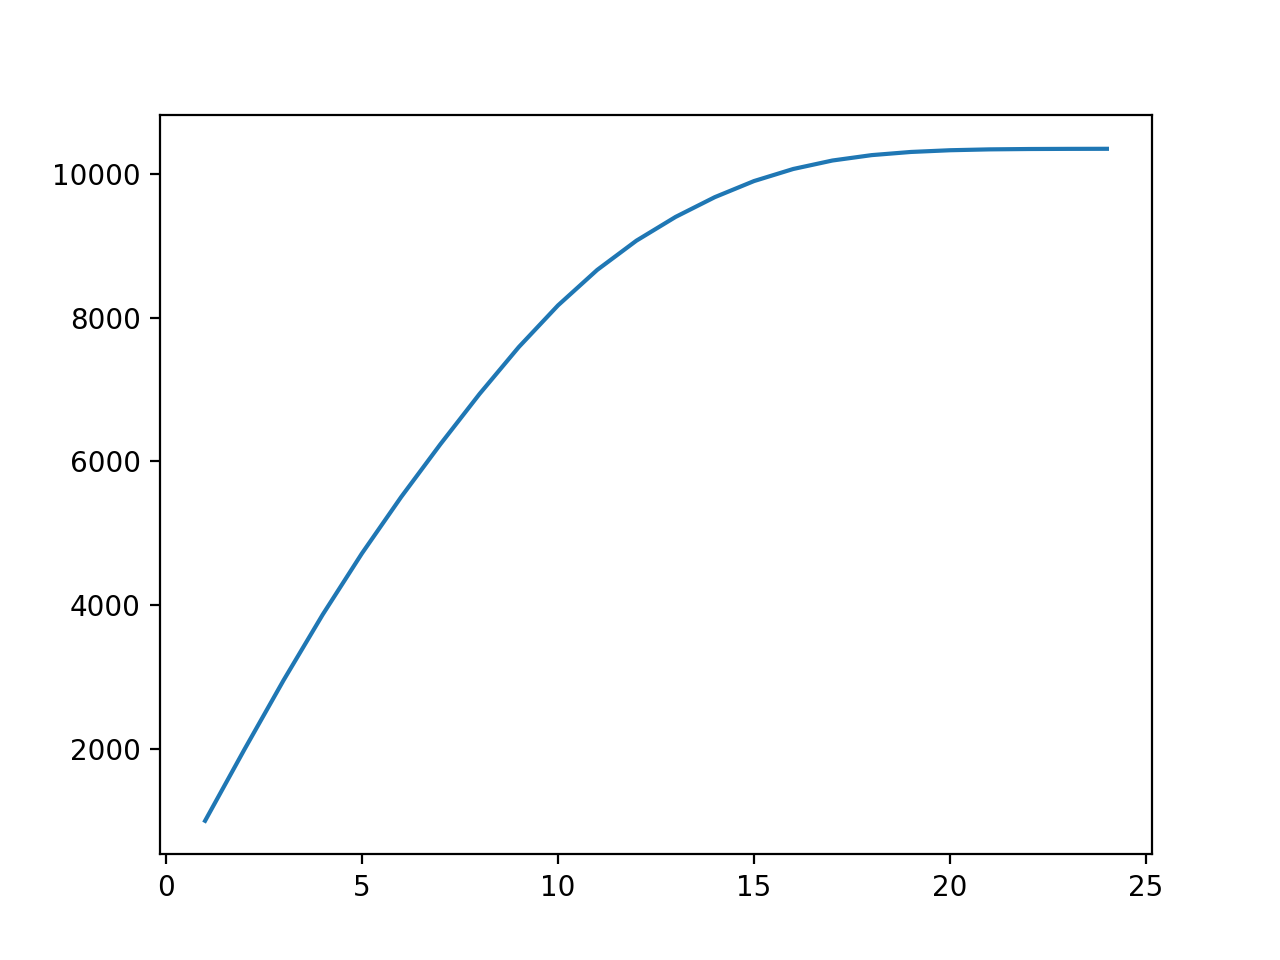

(39995.18483814307, (1, 0, 0, 0))

In [3]:
#%% Figure 2 aus Koch
capacities = np.arange(24)+1

value_exact = np.zeros_like(capacities)
for capacity in capacities:
    value_exact[capacity-1] = value_expected(capacity, 39)[0]

plt.close()
plt.plot(capacities, value_exact)
plt.show()

#%% Ergebnis Tabelle 1 aus Koch
value_expected(40, 399)